# Modeling citibike data
## In this notebook, I create some models to predict the total number of daily Citibike rides based on a set of features identified during EDA.

https://github.com/andypicke/NYC_citibike/blob/master/citibike_regression_new.ipynb

### Import libraries and set some defaults for nice plots.

In [1]:
# %load /Users/Andy/jupyter_imports.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# make plots look nice
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['lines.linewidth'] = 3


### Load the full combined dataset, which was made in the notebook *citibike_regression_make_data*


In [2]:
df_comb = pd.read_csv('data/data_comb.csv')
df_comb.head()

,yday,Nrides,date,Tmean,precip_In,max_gust_mph,cloud_cover,N_stations,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,public
0,182,16650,2013-07-01,76,0.73,26.0,8,326,0,0,0,0,0,0,0.0
1,183,22745,2013-07-02,78,0.06,23.0,7,327,1,0,0,0,0,0,0.0
2,184,21864,2013-07-03,80,0.96,23.0,7,326,0,1,0,0,0,0,0.0
3,185,22326,2013-07-04,84,0.00,24.0,4,324,0,0,1,0,0,0,0.0
4,186,21842,2013-07-05,85,0.00,23.0,1,325,0,0,0,1,0,0,0.0


In [3]:
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 15 columns):
yday            1176 non-null int64
Nrides          1176 non-null int64
date            1176 non-null object
Tmean           1176 non-null int64
precip_In       1176 non-null float64
max_gust_mph    1173 non-null float64
cloud_cover     1176 non-null int64
N_stations      1176 non-null int64
wkday_1         1176 non-null int64
wkday_2         1176 non-null int64
wkday_3         1176 non-null int64
wkday_4         1176 non-null int64
wkday_5         1176 non-null int64
wkday_6         1176 non-null int64
public          1176 non-null float64
dtypes: float64(3), int64(11), object(1)
memory usage: 137.9+ KB


## Split the data into predictor (X) and target (y) arrays in prep for modelling
I drop 'Nrides', which is the target variable, and 'yday and 'date' which I will not be using as a predictor.

In [4]:
X = df_comb.drop(columns=['date','Nrides','yday'], axis=1)
X.head()

,Tmean,precip_In,max_gust_mph,cloud_cover,N_stations,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,public
0,76,0.73,26.0,8,326,0,0,0,0,0,0,0.0
1,78,0.06,23.0,7,327,1,0,0,0,0,0,0.0
2,80,0.96,23.0,7,326,0,1,0,0,0,0,0.0
3,84,0.00,24.0,4,324,0,0,1,0,0,0,0.0
4,85,0.00,23.0,1,325,0,0,0,1,0,0,0.0


In [5]:
y = df_comb['Nrides']
y.head()

0    16650
1    22745
2    21864
3    22326
4    21842
Name: Nrides, dtype: int64

## Next I split the data into training and test sets for modeling.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=39)

## Model 1: Simple Linear Regression
- The first baseline model I will try is the simplest: a multiple linear regression.
- First I need to impute some missing values in the dataset. I will fill in missing values with the mean, using Imputer from sklearn.

In [7]:
from sklearn.preprocessing import Imputer

imp = Imputer(strategy='mean')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test  = imp.transform(X_test)
X_all   = imp.transform(X)


### Now time to fit the model

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

reg = LinearRegression()  # instantiate model object
reg.fit(X_train,y_train)  # fit model
reg.score(X_train, y_train) # score on training data

0.8285467376003368

Using *cross_val_score* gives a better estimate of how the model will perform on unseen data.

In [9]:
cv_score_linreg = np.mean(cross_val_score(reg, X_train, y_train))
print(cv_score_linreg)

0.8180402624574454

We can check the score on the test set also.

In [10]:
# score on test set
lin_reg_test_score=reg.score(X_test,y_test)
lin_reg_test_score

0.8135628727158369

And compute RMSE for comparison w/ other models as well.

In [11]:
from sklearn.metrics import mean_squared_error
RMSE_linreg = mean_squared_error(y_test, reg.predict(X_test))**0.5
RMSE_linreg

5924.665844564357

## Scatterplot actual vs predicted values from test set

/Users/Andy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


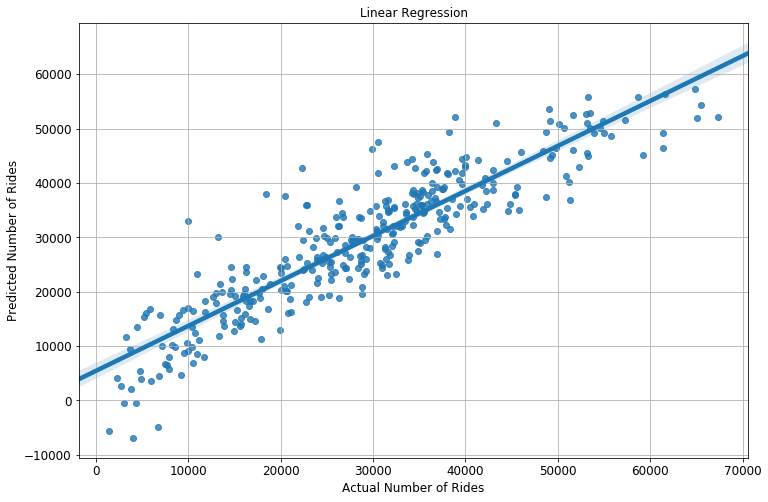

In [12]:
# plot predictions vs actual values
preds = reg.predict(X_test) # make predictions
plt.figure(figsize=(12,8))
sns.regplot(y_test,preds)
plt.xlabel('Actual Number of Rides')
plt.ylabel('Predicted Number of Rides')
plt.title('Linear Regression')
plt.grid();

plt.savefig('/Users/Andy/andypicke.github.io/images/Citibike/linreg_vs_actual.png')


### Plot the timeseries of actual and predicted values from linear regression

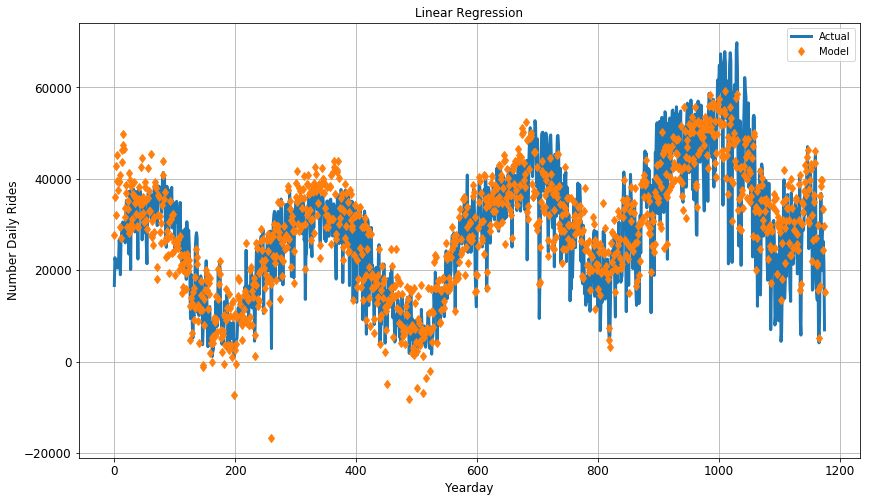

In [13]:
#
plt.figure(figsize=(14,8))
plt.plot(y,label='Actual')
plt.plot(reg.predict(X_all),'d',label='Model')
plt.legend();
plt.xlabel('Yearday')
plt.ylabel('Number Daily Rides')
plt.title('Linear Regression')
plt.grid();

plt.savefig('/Users/Andy/andypicke.github.io/images/Citibike/linreg_vs_actual_timeseries.png')

### Model 2: Next i'll try a Random forest regression

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train,y_train)
rf.score(X_train, y_train)

/Users/Andy/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.9775367157884189

In [15]:
np.mean(cross_val_score(rf,X_train,y_train))

0.8492788229709785

In [16]:
rf.score(X_test,y_test)

0.8831218780786286

In [17]:
RMSE_rf = mean_squared_error(y_test, rf.predict(X_test))**0.5
RMSE_rf

4690.987458246692

### Model 3: Random Forest optimized w/ gridsearchCV
- Let's see if we can improve the performance of the random forest model by doing some hyperparameter tuning.

In [18]:
# optimize RF
from sklearn.model_selection import GridSearchCV

# grid of params to tune over
params = {'n_estimators':[10,50,100,150],
          'min_samples_split':[2,5,10] }

rf2 = RandomForestRegressor()
cv = GridSearchCV(rf2, params)
cv.fit(X_train, y_train)
rf2 = cv.best_estimator_
np.mean( cross_val_score(rf2, X_train, y_train) )

0.8679546096300257

In [19]:
rf2.score(X_test, y_test)

0.8885318835967604

In [20]:
RMSE_rf2= mean_squared_error(y_test, rf2.predict(X_test))**0.5
RMSE_rf2

4581.133953398355

/Users/Andy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


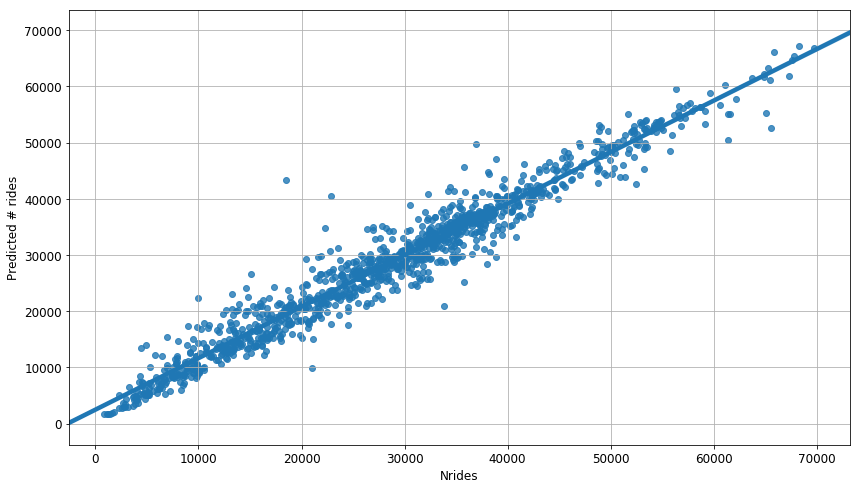

In [30]:
plt.figure(figsize=(14,8))
sns.regplot(y,rf2.predict(X_all))
plt.grid()
plt.ylabel('Predicted # rides')

plt.savefig('/Users/Andy/andypicke.github.io/images/Citibike/rf_vs_actual.png')


### Compare RMSE from the 3 models

In [28]:
# Compare RMSE
print('Lin Reg.     : ' + str(RMSE_linreg))
print('Rand Forest  : ' + str(RMSE_rf))
print('Rand Forest opti.  : ' + str(RMSE_rf2))


Lin Reg.     : 5924.665844564357
Rand Forest  : 4690.987458246692
Rand Forest opti.  : 4581.133953398355


## Variable importance
Examining the variable importance from the model shows that the 3 most important variables are temperature, the number of stations, and precipitation. 

In [23]:
rf_imp = pd.DataFrame({'vars':X.columns,'imp':rf.feature_importances_})
rf_imp.sort_values('imp',ascending=False)

,vars,imp
0,Tmean,0.531921
4,N_stations,0.278861
1,precip_In,0.105064
3,cloud_cover,0.021947
2,max_gust_mph,0.018876
10,wkday_6,0.018181
9,wkday_5,0.011947
6,wkday_2,0.004160
11,public,0.002814
5,wkday_1,0.002503


### Plot model residuals for both linear regression and random forest
- The plot below shows that the residuals are significantly reduced by the random forest model. 
- However there are still a small number of large residuals remaining.

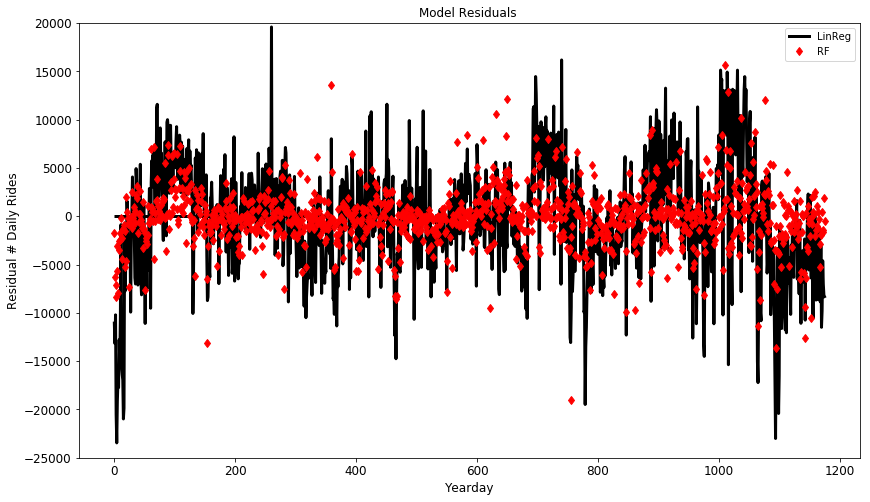

In [24]:
plt.figure(figsize=(14,8))
#plt.plot(y,label='Actual')
plt.plot(y-reg.predict(X_all),'k',label='LinReg')
plt.plot(y-rf.predict(X_all),'rd',label='RF')
plt.legend();
plt.xlabel('Yearday')
plt.ylabel('Residual # Daily Rides')
plt.title('Model Residuals ');
plt.hlines(xmin=0,xmax=360,y=0);
plt.ylim(-25000,20000)

plt.savefig('/Users/Andy/andypicke.github.io/images/Citibike/linreg_rf_residuals.png')


### Look at dates of residuals to see if any are holidays etc:

In [25]:
X2 = df_comb.copy()
# add residuals 
X2['resid'] = y - reg.predict(X_all)
#X2.head()

## What dates do largest residuals fall on?
Sorting by residual, we can see that a lot of the largest negative residuals (model overpredicts actual value) occur near holidays (July 4th, Christmas, Thanksgiving). We did include holidays in the model, but the day or two before/after a holiday are also strongly affected. This makes sense; people often take off multiple days or a long weekend for big holidays. If really wanted to try to capture this behavior, we might create a 'near holiday' variable this is 1 on the day or two before/after a holiday.

In [26]:
X2[['resid','date']].sort_values('resid').head(10)

,resid,date
4,-23457.483704,2013-07-05
1094,-23002.179137,2016-12-25
15,-20979.056450,2013-07-18
3,-20503.650893,2013-07-04
1099,-20413.004310,2017-01-02
16,-19863.673724,2013-07-19
779,-19483.244629,2015-12-24
5,-19107.903351,2013-07-06
7,-17724.623738,2013-07-08
1065,-17219.932118,2016-11-25


Looking at the positive residuals (model underestimates actual values), there isn't any obvious pattern that jumps out to me. These could be days there were special events (races, concerts etc.) that disrupted the usual transportation patterns.

In [27]:
X2[['resid','date']].sort_values('resid').tail(10)

,resid,date
912,13251.521710,2016-06-02
1004,13604.826915,2016-09-16
1005,14157.219264,2016-09-17
1043,14443.317593,2016-11-02
697,14449.835545,2015-09-25
1014,14912.695199,2016-09-26
1031,15114.680414,2016-10-20
1003,15120.889805,2016-09-15
740,16168.785091,2015-11-11
260,19579.541596,2014-04-30


# Conclusions
- We built several models to predict the number of NYC Citibike rides taken on a certain date.
- The baseline model, a simple linear regression, performed fairly well with a cross-validated estimated R^2 of 0.82.
- A random forest regressor had a cross-validated estimated R^2 of 0.85.
- Hyperparameter tuning of the random forest improved the cross-validated estimate of R^2 to 0.86.
- This model had a R^2 of 0.89 on the test set.
- Examining residuals suggests that the model is significantly overpredicting on days surrounding holidays; this could be an area for future improvement. 